In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import pytz as pytz
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.simulator as sim
import pyPIPS.radarmodule as pyPIPSradar
import pyPIPS.PIPS as pips
import pyPIPS.pips_io as pips_io
import pyPIPS.parsivel_qc as pqc
import pyPIPS.parsivel_params as pp
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909', '033116'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis
casedate = '033116'

# Import the file containing the dictionaries needed to gather the radar, disdrometer, and model data.
sys.path.append('/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/configs/2016_IOP3')

from PIPSsim_1km_dicts import *

init_radar_dict = init_radar_dict[casedate]
init_dis_dict = init_dis_dict[casedate]
init_model_dict = init_model_dict[casedate]

load_pkl = True

In [ ]:
import pickle

pkl_dir = '/Users/ddawson/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/data/radar_data/pkl'
pkl_file = '{}_KGWX.pkl'.format(casedate)
pkl_path = os.path.join(pkl_dir, pkl_file)

# Now go ahead and read in the sweeps for the desired case
if not load_pkl:
    radar_dict = sim.read_sweeps(init_radar_dict)
    # Dump radar dictonary to pickle file
    with open(pkl_path, 'wb') as pkl_file_obj:
        pickle.dump(radar_dict, pkl_file_obj)
else:
    with open(pkl_path, 'rb') as pkl_file_obj:
        radar_dict = pickle.load(pkl_file_obj)

In [3]:
# Now go ahead and read in the sweeps for the desired case
radar_dict = sim.read_sweeps(init_radar_dict)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_233553.663_to_20160331_234010.581_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:35:53 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_223343.424_to_20160331_223746.038_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:33:43 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_232035.774_to_20160331_232438.497_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:20:35 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_225416.507_to_20160331_225824.478_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:54:16 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_231525.783_to_20160331_231933.619_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:15:25 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_225928.203_to_20160331_230336.351_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:59:28 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_231009.612_to_20160331_231422.770_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 23:10:09 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_223849.284_to_20160331_224244.646_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 22:38:49 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_222409.899_to_20160331_222745.586_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:24:09 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_220855.137_to_20160331_221221.493_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:08:55 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_230443.929_to_20160331_230904.369_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.8129883
Time of sweep =  2016-03-31 23:04:43 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_220034.035_to_20160331_220342.729_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:00:34 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_224910.491_to_20160331_225313.332_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:49:10 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_233044.114_to_20160331_233446.376_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:30:44 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_232540.010_to_20160331_232942.705_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 23:25:40 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_221324.459_to_20160331_221637.372_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:13:24 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_220444.462_to_20160331_220752.822_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:04:44 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_222848.491_to_20160331_223242.346_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:28:48 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_221946.379_to_20160331_222307.878_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:19:46 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_224349.896_to_20160331_224806.980_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:43:49 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


In [ ]:
# Go ahead and read in the conventional data at the sweeptimes and plot them:
# %matplotlib notebook
plotdir = '/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/plots'
radlims = [0.0, 250000., 0., 360.]
plotlims = [-1, -1, -1, -1]
ovrmap = False # Currently not working
ovrdis = False
dis_name_list = None
dxy_list = None
fields_D_list = None
deg2rad = np.pi / 180.

# Read time series
dis_dict_at_radar = sim.read_convdata_at_sweeptimes(init_dis_dict, radar_dict)

# Find disdrometer lat/lons and convert them to cartesian coordinates relative to radar lat/lon

dis_dict = sim.get_dis_locs_relative_to_radar(init_dis_dict, radar_dict)

dxlist = [i[0] for i in dis_dict['dradloclist']]
dylist = [i[1] for i in dis_dict['dradloclist']]

# Set plotting limits to center on the disdrometer locations 
if plotlims[0] == -1:
    Dxmin = min(dxlist)
    Dxmax = max(dxlist)
    Dymin = min(dylist)
    Dymax = max(dylist)
    plotlims = [Dxmin - 15000., Dxmax + 15000., Dymin - 15000., Dymax + 15000.]

# Extract stuff from radar dictionary
sweeptimelist = radar_dict['sweeptimelist']
radarsweeplist = radar_dict['radarsweeplist']
outfieldnames = radar_dict['outfieldnameslist'][0] # Just need first entry

# Extract stuff from disdrometer dictionary
templist = dis_dict_at_radar['convdata_at_sweeptimes']['temp']
dewpointlist = dis_dict_at_radar['convdata_at_sweeptimes']['dewpoint']
pressurelist = dis_dict_at_radar['convdata_at_sweeptimes']['pressure']
windspdavgveclist = dis_dict_at_radar['convdata_at_sweeptimes']['windspdavgvec']
winddiravgveclist = dis_dict_at_radar['convdata_at_sweeptimes']['winddiravgvec']


for i, sweeptime in enumerate(sweeptimelist):
    print("i, sweeptime = ", sweeptime)
    figlist, gridlist = pyPIPSradar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[i], ovrmap, 
                                                    ovrdis, dis_name_list, dxy_list, fields_D_list, alpha=0.5)
    ax = gridlist[0][0]
    
    for j, Dx, Dy in zip(range(len(dxlist)), dxlist, dylist):
        stationplot = StationPlot(ax, [Dx], [Dy])
        stationplot.plot_parameter('NW', [templist[j][i]], color='purple')
        stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
        stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
        u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
        stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))
        
        ax.text(Dx - 5000, Dy, dis_dict_at_radar['dis_names'][j], fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.5))

    figlist[0].canvas.draw()
    figlist[0].set_size_inches(10., 10., forward = True)
    figname = 'PIPS_station_{}.png'.format(sweeptime.strftime('%Y%m%d%H%M%S'))
    figpath = os.path.join(plotdir, figname)
    plt.savefig(figpath, dpi=300, bbox_inches='tight')

In [ ]:
# Now do the same for the model output
# First set up some stuff

def get_ARPS_member_dir_and_prefix(member, cycle):
    """
    Gets the proper form for the subdirectory and file prefix name given a member number
    and cycle type (either 'posterior' or 'prior'). member number 0 is interpreted as the mean. 
    """
    if member == 0:
        if cycle in 'posterior':
            member_dir = 'ENamean'
            member_prefix = 'enmean'
        elif cycle in 'prior':
            member_dir = 'ENfmean'
            member_prefix = 'efmean'
    else:
        if cycle in 'posterior':
            member_dir = 'EN{:03d}'.format(int(member))
            member_prefix = 'ena{:03d}'.format(int(member))
        elif cycle in 'prior':
            member_dir = 'ENF{:03d}'.format(int(member))
            member_prefix = 'enf{:03d}'.format(int(member))
    
    return member_dir, member_prefix

modelname = 'ARPS'
microphys = 'ZVD'

# From desired start and end times (UTC) get a range of datetimes and corresponding range of times in
# seconds since model initial time
timestamp_model_init = init_model_dict['timestamp_model_init']  # Start time of model corresponding to 0 s
datetime_model_init = datetime.strptime(timestamp_model_init, '%Y%m%d%H%M%S')

timestamp_start = init_model_dict['timestamp_model_start']  # Start time of desired time window
timestamp_stop = init_model_dict['timestamp_model_stop']  # Stop time of desired time window
datetime_start = datetime.strptime(timestamp_start, '%Y%m%d%H%M%S')
datetime_stop = datetime.strptime(timestamp_stop, '%Y%m%d%H%M%S')
tintv = init_model_dict['model_dt']  # Interval in seconds for model output
tintv_mean = init_model_dict['model_dt_mean'] # Interval in seconds for ensemble mean analysis

datetime_range = CRMutils.get_datetime_range(datetime_start, datetime_stop, tintv)
trange = CRMutils.modeltimes_from_datetimes(datetime_range, datetime_start=datetime_model_init)

datetime_range_mean = CRMutils.get_datetime_range(datetime_start, datetime_stop, tintv_mean)
trange_mean = CRMutils.modeltimes_from_datetimes(datetime_range_mean, datetime_start=datetime_model_init)

#basedir = '/Volumes/scr_fast/Projects/VORTEXSE/simulations/ARPS/2016_IOP3/3DVAR/1km0331163DVARCA00005min180_3km030015min540'
fileformat = init_model_dict['fileformat']
expname = '1km453x453_newse'
basedir = init_model_dict['basedirname']
member = 1 # 0 is for ensemble mean
cycle = 'posterior'
member_dir, member_prefix = get_ARPS_member_dir_and_prefix(member, cycle)
member_absdir = os.path.join(basedir, expname, member_dir)
trailer = ''
nproc_x = 15
nproc_y = 6

if member == 0:
    model_trange_sec = trange_mean
    model_datetime_range = datetime_range_mean
else:
    model_trange_sec = trange
    model_datetime_range = datetime_range
    
model_dict = init_model_dict.copy()

model_dict['trange_member'] = trange
model_dict['trange_mean'] = trange_mean
model_dict['datetime_range_member'] = datetime_range
model_dict['datetime_range_mean'] = datetime_range_mean


if member == 0:
    model_dict['trange'] = trange_mean
    model_dict['datetime_range'] = datetime_range_mean
else:
    model_dict['trange'] = trange
    model_dict['datetime_range'] = datetime_range
    
print(model_datetime_range)

In [ ]:
# Load the ARPS grid
# Get file path for grdbas file (note that call to read_grid handles the reading of the individual patches)
# If the grdbas file doesn't exist, fall back to a history file
grdbas_path = arps_read.get_file_path(member_absdir, member_prefix, fileformat, filetype='grdbas')

patch_x = 1
patch_y = 1
grdbas_path_test = arps_read.add_patch_number(grdbas_path, patch_x, patch_y)

if not os.path.exists(grdbas_path_test):
    print("grdbas file doesn't exist, trying a history file!")
    grdbas_path = arps_read.get_file_path(member_absdir, member_prefix, fileformat, time=model_trange_sec[0], 
                                          filetype='history')
    grdbas_path_test = arps_read.add_patch_number(grdbas_path, patch_x, patch_y)

    print(grdbas_path_test)
    print(os.path.exists(grdbas_path_test))

# Read in grid information
grid_dict = arps_read.readarpsgrid(grdbas_path, nproc_x=nproc_x, nproc_y=nproc_y)
print(grid_dict.keys())

# Get map projection information and create a Basemap instance
# TODO: convert to use cartopy!

ctrlat, ctrlon, trulat1, trulat2, trulon = arps_read.readarpsmap(grdbas_path, nproc_x=nproc_x, nproc_y=nproc_y)

dx = grid_dict['dx']
dy = grid_dict['dy']
nx = grid_dict['nx']
ny = grid_dict['ny']

mapwidth = nx * dx
mapheight = ny * dy

bgmap = Basemap(projection='lcc', width=mapwidth, height=mapheight, lat_1=trulat1,
                lat_2=trulat2, lat_0=ctrlat, lon_0=ctrlon, resolution='h',
                area_thresh=10., suppress_ticks=False)



In [ ]:
# Put the basemap instance into the grid_dict
grid_dict['bgmap'] = bgmap

# Find coordinates of PIPS stations in the model
dis_dict = sim.get_dis_locs_arps_real_grid(dis_dict, grid_dict)


coord_array = np.array(dis_dict['dmodcrdlist'])

print(coord_array) 
print(coord_array.shape) 
print(coord_array[0]) 
# coord_array = coord_array.T

In [ ]:
# Plot the PIPS station models on the ARPS model grid, similar to what was done with the radar sweep files
dilist = [i[0] for i in dis_dict['dmodcrdlist']]
djlist = [i[1] for i in dis_dict['dmodcrdlist']]

print(dilist)
print(djlist)

dxlist = [i[0] for i in dis_dict['dmodloclist']]
dylist = [i[1] for i in dis_dict['dmodloclist']]

print(dxlist)
print(dylist)

xc = grid_dict['xs']
yc = grid_dict['ys']
xe = grid_dict['x']
ye = grid_dict['y']

xckm = xc / 1000.
yckm = yc / 1000.
xekm = xe / 1000.
yekm = ye / 1000.

# Set plotting limits to center on the disdrometer locations 

Dxmin = min(dxlist)
Dxmax = max(dxlist)
Dymin = min(dylist)
Dymax = max(dylist)
plotlims = [Dxmin - 25000., Dxmax + 25000., Dymin - 25000., Dymax + 25000.]

ibgn = np.searchsorted(xc, plotlims[0])
iend = np.searchsorted(xc, plotlims[1]) + 1
jbgn = np.searchsorted(yc, plotlims[2])
jend = np.searchsorted(yc, plotlims[3]) + 1

print(plotlims)
print(ibgn, iend, jbgn, jend)

plotvar_dict = {
    'xcplt': xckm,
    'ycplt': yckm,
    'xeplt': xekm,
    'yeplt': yekm,
}

plotparam_dict = {
    'cmap': pyPIPSradar.cmapdBZ,
    'fieldlevels': np.arange(5.0, 85.0, 5.0),
    'clvls': matplotlib.ticker.MultipleLocator(base=5.0),
    'clabel': r'dBZ',
    'cformat': None,
}

plotparam_dict['norm'] = matplotlib.colors.BoundaryNorm(plotparam_dict['fieldlevels'], 
                                                        plotparam_dict['cmap'].N)

axesparam_dict = {
    'axis_ticks': (10000., 10000.),
    'axis_names': ('x', 'y')
}

plotlim_dict = {
    'x': (plotlims[0], plotlims[1]),
    'y': (plotlims[2], plotlims[3])
}

plotvar_name = 'dBZmod'


dis_dict_at_model = sim.read_convdata_at_modeltimes(init_dis_dict, model_dict)

# Extract stuff from disdrometer dictionary
templist = dis_dict_at_model['convdata_at_modeltimes']['temp']
dewpointlist = dis_dict_at_model['convdata_at_modeltimes']['dewpoint']
pressurelist = dis_dict_at_model['convdata_at_modeltimes']['pressure']
windspdavgveclist = dis_dict_at_model['convdata_at_modeltimes']['windspdavgvec']
winddiravgveclist = dis_dict_at_model['convdata_at_modeltimes']['winddiravgvec']

print(templist)

for i, time in enumerate(model_trange_sec):
    print("Loading time ", time) 
    filepath = arps_read.get_file_path(member_absdir, member_prefix, fileformat, time=time, filetype='history')
    print(filepath)
    
    var_read_dict = {}
    var_read_dict = pycaps_fields.get_fields(var_read_dict, field_names=[plotvar_name], path_grdbas=grdbas_path, 
                                             path_hdf=filepath, ibgn=ibgn, jbgn=jbgn, iend=iend, jend=jend, 
                                             klvls=[2], multipatch=True, grid_dict=grid_dict, 
                                             ignore_existing_vars=True, nproc_x=nproc_x, nproc_y=nproc_y)
    
    plotvar_dict = plotmod.init_plotvar_dict(plotvar_name, var_read_dict[plotvar_name], 0, 1, grid_dict)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plotmod.plot2D(fig, ax, 'pcolor', plotvar_dict, plotparam_dict)
    
    plotmod.set_plot_axes(ax, plotlim_dict, axesparam_dict)

    for j, Dx, Dy in zip(range(len(dxlist)), dxlist, dylist):
        stationplot = StationPlot(ax, [Dx], [Dy])
        stationplot.plot_parameter('NW', [templist[j][i]], color='red')
        stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
        stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
        u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
        stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))
    
    figname = 'PIPS_station_model_{}.png'.format(model_datetime_range[i].strftime('%Y%m%d%H%M%S'))
    figpath = os.path.join(plotdir, figname)
    plt.savefig(figpath, dpi=300, bbox_inches='tight') 
    
# figlist, gridlist = pyPIPSradar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[i], ovrmap, 
#                                                     ovrdis, dis_name_list, dxy_list, fields_D_list)
#     ax = gridlist[0][0]
    
#     for j, Dx, Dy in zip(range(len(dxlist)), dxlist, dylist):
#         stationplot = StationPlot(ax, [Dx], [Dy])
#         stationplot.plot_parameter('NW', [templist[j][i]], color='red')
#         stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
#         stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
#         u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
#         stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))

#     figlist[0].canvas.draw()
#     figlist[0].set_size_inches(10., 10., forward = True)
#     figname = 'PIPS_station_{}.png'.format(sweeptime.strftime('%Y%m%d%H%M%S'))
#     figpath = os.path.join(plotdir, figname)
#     plt.savefig(figpath, dpi=300, bbox_inches='tight')

In [ ]:
# Read in PIPS data

print(dis_dict.keys())

dis_dir = dis_dict['dis_dir']
dis_filenames = dis_dict['disfilenames']
dis_names = dis_dict['dis_names']

conv_df_dict = {}
parsivel_df_dict = {}
vd_matrix_da_dict = {}

for dis_filename, dis_name in zip(dis_filenames, dis_names):
    dis_filepath = os.path.join(dis_dir, dis_filename)
    print("Reading {}".format(dis_filepath))
    conv_df, parsivel_df, vd_matrix_da = pips_io.read_PIPS(dis_filepath, starttimestamp=timestamp_start,
                                                           stoptimestamp=timestamp_stop)
    # Calculate some additional thermodynamic quantities and add to the conventional data DataFrame
    conv_df = pips.calc_thermo(conv_df)
    conv_df_dict[dis_name] = conv_df
    parsivel_df_dict[dis_name] = parsivel_df
    vd_matrix_da_dict[dis_name] = vd_matrix_da

In [ ]:
# Resample PIPS data to a 60-s interval
conv_rs_df_dict = {}
parsivel_rs_df_dict = {}
vd_matrix_rs_da_dict = {}
for dis_name in dis_names:
    # Conventional data
    conv_df = conv_df_dict[dis_name]
    datetime_range_onesec = conv_df.index.to_pydatetime()
    sec_offset = pips.get_offset_seconds(datetime_range_onesec)
    conv_rs_df_dict[dis_name] = pips.resample_conv('PIPS', 60., sec_offset, conv_df)
    
    # Parsivel 10-s derived fields
    parsivel_df = parsivel_df_dict[dis_name]
    datetime_range_tensec = parsivel_df.index.to_pydatetime()
    sec_offset = pips.get_offset_seconds(datetime_range_tensec)
    print(sec_offset)
    parsivel_rs_df_dict[dis_name] = pips.resample_parsivel(60., parsivel_df)
    
    # Parsivel V-D matrix
    vd_matrix_da = vd_matrix_da_dict[dis_name]
    vd_matrix_rs_da_dict[dis_name] = pips.resample_vd_matrix(60., vd_matrix_da)

In [33]:
# Compute N(D) for the observed PIPS DSDs after some QC
min_diameters = pp.parsivel_parameters['min_diameter_bins_mm']
mid_diameters = pp.parsivel_parameters['avg_diameter_bins_mm']
max_diameters = pp.parsivel_parameters['max_diameter_bins_mm']
mid_fallspeeds = pp.parsivel_parameters['avg_fallspeed_bins_mps']
empirical_fallspeed = pips.calc_empirical_fallspeed(mid_diameters)
fallspeed_spectrum = pips.calc_fallspeed_spectrum(mid_diameters, mid_fallspeeds, use_measured_fallspeed=True)

ND_PIPS_dict = {}
logND_PIPS_dict = {}
PSD_datetimes_rs_PIPS_dict = {}

for dis_name in dis_names:
    vd_matrix_rs_da = vd_matrix_rs_da_dict[dis_name]
    vd_matrix_rs_QC = pqc.strongwindQC(vd_matrix_rs_da)
    vd_matrix_rs_QC = pqc.rainonlyQC(vd_matrix_rs_QC)
    # Calculate ND and log10(ND)
    ND = pips.calc_ND(vd_matrix_rs_QC.where(vd_matrix_rs_QC > 0.0), fallspeed_spectrum, 60.)
    logND = np.log10(ND)
    logND = logND.where(logND > -1.0)
    
    ND_PIPS_dict[dis_name] = ND
    logND_PIPS_dict[dis_name] = logND
    # Get times for PIPS transects as numpy arrays of python datetime objects
    PSD_datetimes_rs = pips.get_PSD_datetimes(vd_matrix_rs_da)
    PSD_datetimes_rs_dict = pips.get_PSD_time_bins(PSD_datetimes_rs)
    PSD_datetimes_rs_PIPS_dict[dis_name] = PSD_datetimes_rs_dict

65
84
45


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


95


In [42]:
# Compute some radar and DSD parameters from DSD
dBZ_PIPS_dict = {}
D0_PIPS_dict = {}
for dis_name in dis_names:
    dBZ_PIPS = dsd.calc_dBZ_from_bins(ND_PIPS_dict[dis_name])
    dBZ_PIPS = dBZ_PIPS.where(dBZ_PIPS > -np.inf)
    dBZ_PIPS_dict[dis_name] = dBZ_PIPS
    D0_PIPS = dsd.calc_D0_bin(ND_PIPS_dict[dis_name])
    D0_PIPS_dict[dis_name] = D0_PIPS

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [ ]:
dateformat = '%H:%M' 
formatter = dates.DateFormatter(dateformat)
locator = dates.MinuteLocator(byminute=[0, 15, 30, 45])
minorlocator = None
timelabel = 'Time (HH:MM)'
xaxislimits = [dates.date2num(datetime_range[0]), dates.date2num(datetime_range[-1])]
meteo_T_Td_range = [10., 25.]

for i, dis_name in enumerate(dis_names):
    conv_rs_df = conv_rs_df_dict[dis_name]
    datetimes_PIPS_conv = conv_rs_df.index.to_pydatetime()
    plottimes = dates.date2num(datetimes_PIPS_conv)
    T_PIPS = conv_rs_df['fasttemp']
    Td_PIPS = conv_rs_df['dewpoint']
   
    fig, ax = plt.subplots()
    fields = [T_PIPS, Td_PIPS]
    fieldparamdicts = [PIPSplot.temp_params, PIPSplot.dewpoint_params]
    ax = PIPSplot.plotmeteogram(ax, [plottimes], fields, fieldparamdicts)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [xaxislimits, meteo_T_Td_range],
                    'axeslabels': [timelabel, r'Temperature ($^{\circ}$C)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
    #ax.plot(trange, T_model[:, i], color = 'r')
    #ax.set_xlim(tstart, tstop)
    #ax.set_ylim(15.0, 30.0)

In [54]:
# Plot observed DSD meteograms
meteogram_plotdir = os.path.join(plotdir, 'meteograms')
if not os.path.exists(meteogram_plotdir):
    os.makedirs(meteogram_plotdir)

# Prepare axis parameters
# We'll use the model times just for the boundaries of the x-axis
timelimits = [datetime_range[0], datetime_range[-1]]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'observed'
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = dates.MinuteLocator(byminute=range(0,60,5))
dateformat = '%H:%M'
formatter = dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

# Ok, now we should have everything ready to go to plot the meteograms.
# Let'er rip!
for i, dis_name in enumerate(dis_names):
    logND = logND_PIPS_dict[dis_name]
    D0 = D0_PIPS_dict[dis_name] * 1000. # Get to mm again
    dBZ = dBZ_PIPS_dict[dis_name]
    PSDstarttimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_edges'])
    PSDmidtimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_centers'])
    disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'D_0': D0, 'dBZ': dBZ}
    
    dis_plot_name = dis_name + '_' + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_plotdir, axparams, disvars)

In [127]:
# Read in the model fields from previously generated netCDF files

# Choose a member
member = 13
member_dir, member_prefix = get_ARPS_member_dir_and_prefix(member, cycle)
ncfilename = member_prefix + '_fields.nc'
ncdir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/vortexse_enkf_dsd_study/data/nc'
ncfilepath = os.path.join(ncdir, ncfilename)

# Open the Dataset
var_ds = xr.open_dataset(ncfilepath)

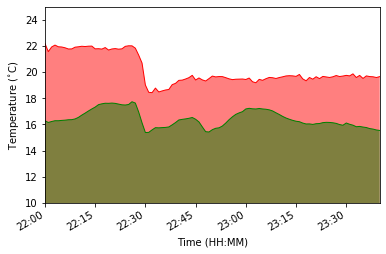

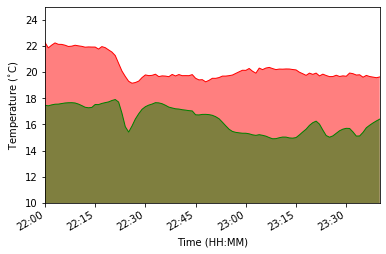

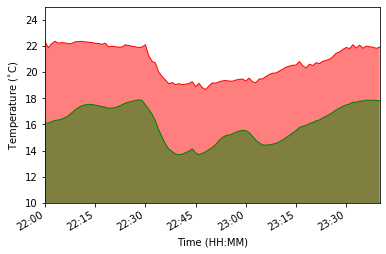

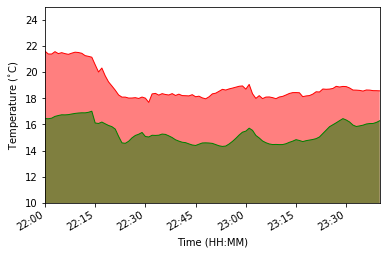

In [ ]:
p_interp = var_ds_interp['p']
pt_interp = var_ds_interp['pt']
qv_interp = var_ds_interp['qv']

T_model_PIPS = thermo.calT(p_interp, pt_interp) - 273.15
Td_model_PIPS = thermo.calTd(p_interp, qv_interp) - 273.15


dateformat = '%H:%M' 
formatter = dates.DateFormatter(dateformat)
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = None
timelabel = 'Time (HH:MM)'
plottimes = dates.date2num(datetime_range)
xaxislimits = [plottimes[0], plottimes[-1]]
meteo_T_Td_range = [10., 25.]

for i, PIPSname in enumerate(dis_dict['dis_names']):
    #print i
    fig, ax = plt.subplots()
    T_model_PIPS_plt = T_model_PIPS.sel(PIPS=PIPSname)
    Td_model_PIPS_plt = Td_model_PIPS.sel(PIPS=PIPSname)
    fields = [T_model_PIPS_plt, Td_model_PIPS_plt]
    fieldparamdicts = [PIPSplot.temp_params, PIPSplot.dewpoint_params]
    ax = PIPSplot.plotmeteogram(ax, [plottimes], fields, fieldparamdicts)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [xaxislimits, meteo_T_Td_range],
                    'axeslabels': [timelabel, r'Temperature ($^{\circ}$C)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
    #ax.plot(trange, T_model[:, i], color = 'r')
    #ax.set_xlim(tstart, tstop)
    #ax.set_ylim(15.0, 30.0)


In [ ]:
# Save for posterity. The DSD parameters are now computed on the model grid first, and then interpolated to
# the PIPS points: EDIT: brought this back. Computing the parameters *first* seems to have problems. I don't
# yet know why.

# Compute raw model DSD at PIPS locations
rhor = 1000.
cr = np.pi / 6. * rhor

qr_model_PIPS = var_ds_interp['qr']
nr_model_PIPS = var_ds_interp['nr']
zr_model_PIPS = var_ds_interp['zr']
rho_model_PIPS = thermo.calrho(p_interp, pt_interp, qv_interp)

# Shape parameter
# alphar_atPIPS = dualpol.solve_alpha_iter(rhoa_atPIPS, mu, qr_atPIPS, nr_atPIPS, zr_atPIPS, rhor)
alphar_model_PIPS = dsd.solve_alpha(rho_model_PIPS, cr, qr_model_PIPS, nr_model_PIPS, zr_model_PIPS)
# Intercept parameter
N0r_model_PIPS = dsd.calc_N0_gamma(rho_model_PIPS, qr_model_PIPS, nr_model_PIPS, cr, alphar_model_PIPS)
# Slope parameter
lamdar_model_PIPS = dsd.calc_lamda_gamma(rho_model_PIPS, qr_model_PIPS, nr_model_PIPS, cr, alphar_model_PIPS)

/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:419: RuntimeWarning: divide by zero encountered in true_divide
  # Correction for fallspeeds at different pressures
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:420: RuntimeWarning: invalid value encountered in multiply
  rho_ref = 1.225
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:139: RuntimeWarning: divide by zero encountered in true_divide
  lamda = np.where(rhoa * q > 0.0, lamda, 0.0)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:139: RuntimeWarning: invalid value encountered in true_divide
  lamda = np.where(rhoa * q > 0.0, lamda, 0.0)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:139: RuntimeWarning: divide by zero encountered in true_divide
  lamda = np.where(rhoa * q > 0.0, lamda, 0.0)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:139: RuntimeWarning: invalid value encountered in true_divide
  lamda = np.where(rhoa * q > 0.0, lamda, 0.0)


In [ ]:
# Save for posterity, now part of var_ds dataset above

# Temp fix until I get the above functions to work properly with xarray
# convert alphar, N0r, lamdar back to DataArrays

alphar_model_allPIPS_da = xr.DataArray(alphar_model_PIPS,
                                    coords={
                                        'time': qr_model_PIPS['time'],
                                        'PIPS': ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS2B']
                                    },
                                    dims=['time', 'PIPS'])
N0r_model_allPIPS_da = xr.DataArray(N0r_model_PIPS,
                                    coords={
                                        'time': qr_model_PIPS['time'],
                                        'PIPS': ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS2B']
                                    },
                                    dims=['time', 'PIPS'])
lamdar_model_allPIPS_da = xr.DataArray(lamdar_model_PIPS,
                                    coords={
                                        'time': qr_model_PIPS['time'],
                                        'PIPS': ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS2B']
                                    },
                                    dims=['time', 'PIPS'])

print(lamdar_model_allPIPS_da)

<xarray.DataArray (time: 101, PIPS: 4)>
array([[10186.264972,  4847.972042, 39717.425252,  6824.048719],
       [ 8599.886423, 86839.331221,  6665.32396 , 11439.619645],
       [11255.70083 ,  4263.366585,  7028.811686, 12150.080717],
       ...,
       [ 2876.028518,  2053.770289,  8070.312741,  3276.919325],
       [ 3034.822182,  2312.658293,  5794.996879,  3220.218909],
       [ 4146.726346,  2711.433676,  6251.622407,  1708.28971 ]])
Coordinates:
  * time     (time) datetime64[ns] 2016-03-31T22:00:00 ... 2016-03-31T23:40:00
  * PIPS     (PIPS) <U6 'PIPS1A' 'PIPS1B' 'PIPS2A' 'PIPS2B'


In [ ]:
# TODO: maybe it's better to try to do this the other direction: namely interpolate the ND values at the PIPS
# times, which are different for each PIPS, to the common model times.

# Now, interpolate these values at the model times to the PIPS DSD times, one PIPS at a time.
# Also get the PSD time bin edges and centers as a numpy array of python datetime objects
model_vars_PIPS_dict = {}
model_gamma_DSD_params_PIPS_modeltimes_dict = {}
model_gamma_DSD_PIPS_modeltimes_dict = {}
model_gamma_DSD_params_PIPS_dict = {}
model_gamma_DSD_PIPS_dict = {}

# Get PSD times valid at the model times
PSD_datetimes_model = pips.get_PSD_datetimes(var_ds, dim_name='time')
PSD_datetimes_model_dict = pips.get_PSD_time_bins(PSD_datetimes_model)

for dis_name in dis_names:
    
    # Get the DataArrays for individual PIPS
    
    # Velocity-diameter matrix
    vd_matrix_rs_da = vd_matrix_rs_da_dict[dis_name]
    
    # Rename "time_10s" to "time" so that we have the same dimension name as the model
    vd_matrix_rs_da = vd_matrix_rs_da.rename({'time_10s': 'time'})
    
    # Shape, intercept, and slope parameters for model DSD, already interpolated in space to each
    # PIPS location
    # New way
    
    
#     alphar_model_PIPS_da = var_ds_interp['alphar'].loc[dict(PIPS=dis_name)]
#     N0r_model_PIPS_da = var_ds_interp['N0r'].loc[dict(PIPS=dis_name)]
#     lamdar_model_PIPS_da = var_ds_interp['lamdar'].loc[dict(PIPS=dis_name)]
    
    # Do the same for ND and logND
    ND_model_PIPS_da = var_ds_interp['ND'].loc[dict(PIPS=dis_name)]
    logND_model_PIPS_da = var_ds_interp['logND'].loc[dict(PIPS=dis_name)]
    
    # Old way
    alphar_model_PIPS_da = alphar_model_allPIPS_da.loc[dict(PIPS=dis_name)]
    N0r_model_PIPS_da = N0r_model_allPIPS_da.loc[dict(PIPS=dis_name)]
    lamdar_model_PIPS_da = lamdar_model_allPIPS_da.loc[dict(PIPS=dis_name)]
    
    # Get the values of some needed variables from the model dataset, already interpolated in space to each
    # PIPS location
    
    # We just need rho and nr
    rho_model_pips_da = var_ds_interp['rho'].loc[dict(PIPS=dis_name)]
    nr_model_pips_da = var_ds_interp['nr'].loc[dict(PIPS=dis_name)]
    
    # Now interpolate the DSD parameters in time to the PIPS times, which are different for each PIPS
    
    alphar_model_PIPS_da_interp = alphar_model_PIPS_da.interp_like(vd_matrix_rs_da)
    N0r_model_PIPS_da_interp = N0r_model_PIPS_da.interp_like(vd_matrix_rs_da)
    lamdar_model_PIPS_da_interp = lamdar_model_PIPS_da.interp_like(vd_matrix_rs_da)
    
    # Do the same for ND and logND
    ND_model_PIPS_da_interp = ND_model_PIPS_da.interp_like(vd_matrix_rs_da)
    logND_model_PIPS_da_interp = logND_model_PIPS_da.interp_like(vd_matrix_rs_da)
    
    # Do the same for rho and nr
    rho_model_pips_da_interp = rho_model_pips_da.interp_like(vd_matrix_rs_da)
    nr_model_pips_da = nr_model_pips_da.interpolate_na(dim='time')
    nr_model_pips_da_interp = nr_model_pips_da.interp_like(vd_matrix_rs_da)
    
    # Stuff them into a dict of dicts (gahhh!)
    model_gamma_DSD_params_modeltimes_dict = {'alphar': alphar_model_PIPS_da,
                                              'N0r': N0r_model_PIPS_da,
                                              'lamdar': lamdar_model_PIPS_da}
    model_gamma_DSD_params_PIPS_modeltimes_dict[dis_name] = model_gamma_DSD_params_modeltimes_dict
    model_gamma_DSD_params_dict = {'alphar': alphar_model_PIPS_da_interp,
                                   'N0r': N0r_model_PIPS_da_interp,
                                   'lamdar': lamdar_model_PIPS_da_interp}
    model_gamma_DSD_params_PIPS_dict[dis_name] = model_gamma_DSD_params_dict
    
    model_gamma_DSD_modeltimes_dict = {'ND': ND_model_PIPS_da, 
                                       'logND': logND_model_PIPS_da}
    model_gamma_DSD_PIPS_modeltimes_dict[dis_name] = model_gamma_DSD_modeltimes_dict
    
    model_gamma_DSD_dict = {'ND': ND_model_PIPS_da_interp,
                            'logND': logND_model_PIPS_da_interp}
    model_gamma_DSD_PIPS_dict[dis_name] = model_gamma_DSD_dict
    
    model_vars_PIPS_dict[dis_name] = {'rho': rho_model_pips_da_interp, 'nr': nr_model_pips_da_interp}

In [ ]:
# Compute N(D) from the raw model parameters at original model times
import pyPIPS.parsivel_params as pp

ND_model_raw_PIPS_modeltimes_dict = {}
logND_model_raw_PIPS_modeltimes_dict = {}
for i, dis_name in enumerate(dis_names):
    mid_diameters_da = vd_matrix_da_dict[dis_name]['diameter']
    alphar_model_PIPS_da = model_gamma_DSD_params_PIPS_modeltimes_dict[dis_name]['alphar']
    N0r_model_PIPS_da = model_gamma_DSD_params_PIPS_modeltimes_dict[dis_name]['N0r']
    lamdar_model_PIPS_da = model_gamma_DSD_params_PIPS_modeltimes_dict[dis_name]['lamdar']
    print(alphar_model_PIPS_da)
    # Broadcast DSD parameter DataArrays to get everyone on the same dimensional page
    mid_diameters_da, N0r_model_PIPS_da, lamdar_model_PIPS_da, alphar_model_PIPS_da = \
        xr.broadcast(mid_diameters_da, N0r_model_PIPS_da, lamdar_model_PIPS_da, alphar_model_PIPS_da)
    # Transpose these DataArrays to get time as the first dimension
    mid_diameters_da = mid_diameters_da.T
    N0r_model_PIPS_da = N0r_model_PIPS_da.T
    lamdar_model_PIPS_da = lamdar_model_PIPS_da.T
    alphar_model_PIPS_da = alphar_model_PIPS_da.T
    
    ND_model_raw_PIPS = dsd.calc_binned_DSD_from_params(N0r_model_PIPS_da, lamdar_model_PIPS_da, 
                                                        alphar_model_PIPS_da, mid_diameters_da)
    logND_model_raw_PIPS = np.log10(ND_model_raw_PIPS)
    logND_model_raw_PIPS = logND_model_raw_PIPS.where(logND_model_raw_PIPS > -1.0)
    
    ND_model_raw_PIPS_modeltimes_dict[dis_name] = ND_model_raw_PIPS
    logND_model_raw_PIPS_modeltimes_dict[dis_name] = logND_model_raw_PIPS

<xarray.DataArray (time: 101)>
array([0.000000e+00, 0.000000e+00, 4.312174e-01, 1.478568e+00, 3.613583e+00,
       3.357149e+00, 2.186511e+00, 1.043923e+00, 1.225902e+00, 2.671333e+00,
       1.863952e+00, 1.434441e+00, 1.947368e+00, 5.258493e+00, 2.545007e+00,
       4.000000e+01, 0.000000e+00, 0.000000e+00, 3.054691e-01, 4.452054e+00,
       1.136262e+01, 1.516423e+00, 5.668679e+00, 2.433907e+00, 6.695544e+00,
       6.596203e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       5.143117e-01, 6.564183e-01, 2.310090e-01, 5.682428e-02, 0.000000e+00,
       4.629651e-01, 3.622250e-01, 2.025199e-01, 6.171094e-02, 0.000000e+00,
       1.456939e-01, 9.124033e-01, 1.066340e+00, 8.497212e-01, 3.326261e-01,
       5.847029e-01, 2.611053e-01, 1.699821e-01, 0.000000e+00, 1.604063e-02,
       4.267835e-01, 2.992920e-01, 3.032826e-01, 1.801024e-01, 0.000000e+00,
       7.231812e-01, 1.862641e+00, 3.037317e+00, 2.956332e+00, 1.764558e+00,
       2.684514e+00, 1.241856e+00, 5.923745e-

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [ ]:
# Compute N(D) from the raw model parameters (interpolated to the PIPS times and locations)
import pyPIPS.parsivel_params as pp

ND_model_raw_PIPS_dict = {}
logND_model_raw_PIPS_dict = {}
for i, dis_name in enumerate(dis_names):
    mid_diameters_da = vd_matrix_da_dict[dis_name]['diameter']
    alphar_model_PIPS_da = model_gamma_DSD_params_PIPS_dict[dis_name]['alphar']
    N0r_model_PIPS_da = model_gamma_DSD_params_PIPS_dict[dis_name]['N0r']
    lamdar_model_PIPS_da = model_gamma_DSD_params_PIPS_dict[dis_name]['lamdar']
    # Broadcast DSD parameter DataArrays to get everyone on the same dimensional page
    mid_diameters_da, N0r_model_PIPS_da, lamdar_model_PIPS_da, alphar_model_PIPS_da = \
        xr.broadcast(mid_diameters_da, N0r_model_PIPS_da, lamdar_model_PIPS_da, alphar_model_PIPS_da)
    # Transpose these DataArrays to get time as the first dimension
    mid_diameters_da = mid_diameters_da.T
    N0r_model_PIPS_da = N0r_model_PIPS_da.T
    lamdar_model_PIPS_da = lamdar_model_PIPS_da.T
    alphar_model_PIPS_da = alphar_model_PIPS_da.T
    
    ND_model_raw_PIPS = dsd.calc_binned_DSD_from_params(N0r_model_PIPS_da, lamdar_model_PIPS_da, 
                                                        alphar_model_PIPS_da, mid_diameters_da)
    logND_model_raw_PIPS = np.log10(ND_model_raw_PIPS)
    logND_model_raw_PIPS = logND_model_raw_PIPS.where(logND_model_raw_PIPS > -1.0)
    
    ND_model_raw_PIPS_dict[dis_name] = ND_model_raw_PIPS
    logND_model_raw_PIPS_dict[dis_name] = logND_model_raw_PIPS

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [161]:
# Compute some radar and DSD parameters from the raw model DSDs (interpolated to PIPS times and locations)
dBZ_raw_model_dict = {}
D0_raw_model_dict = {}
for dis_name in dis_names:
    dBZ_raw_model = dsd.calc_dBZ_from_bins(model_gamma_DSD_PIPS_dict[dis_name]['ND'])
    dBZ_raw_model = dBZ_raw_model.where(dBZ_raw_model > -np.inf)
    dBZ_raw_model_dict[dis_name] = dBZ_raw_model
    D0_raw_model = dsd.calc_D0_bin(model_gamma_DSD_PIPS_dict[dis_name]['ND'])
    D0_raw_model_dict[dis_name] = D0_raw_model

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [ ]:
# # Now plot the raw model DSDs (interpolated to PIPS locations but not the times)

# PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
# PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

# for i, dis_name in enumerate(dis_names):
#     logND = model_gamma_DSD_PIPS_modeltimes_dict[dis_name]['logND']
#     logND = logND.where(logND > -1.0)
#     disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
#                'PSDmidtimes': PSDmidtimes, 'logND': logND.T}
#     dis_plot_name = dis_name + '_raw_model_modeltimes_' + DSDtype
#     PIPSplot.plotDSDmeteograms(dis_plot_name, plotdir, axparams, disvars)

In [ ]:
# # Now plot the raw model DSDs (interpolated to PIPS locations but not the times) - version 2 with logND computed
# # from interpolated alpha, lamda, N0

# PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
# PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

# for i, dis_name in enumerate(dis_names):
#     logND = logND_model_raw_PIPS_modeltimes_dict[dis_name]
#     logND = logND.where(logND > -1.0)
#     print(logND)
#     print(PSDstarttimes)
#     disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
#                'PSDmidtimes': PSDmidtimes, 'logND': logND.T}
#     dis_plot_name = dis_name + '_raw_model_modeltimes_v2_' + DSDtype
#     PIPSplot.plotDSDmeteograms(dis_plot_name, plotdir, axparams, disvars)

In [ ]:
# Now plot the raw model DSDs (interpolated to PIPS times and locations)

for i, dis_name in enumerate(dis_names):
    logND = model_gamma_DSD_PIPS_dict[dis_name]['logND']
    logND = logND.where(logND > -1.0)
    D0 = D0_raw_model_dict[dis_name] * 1000. # Get to mm again
    dBZ = dBZ_raw_model_dict[dis_name]
    PSDstarttimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_edges'])
    PSDmidtimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_centers'])
    disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'D_0': D0, 'dBZ': dBZ}
    dis_plot_name = dis_name + '_raw_model_{:d}'.format(member) + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, plotdir, axparams, disvars)

In [ ]:
# # Now plot the raw model DSDs (interpolated to PIPS times and locations) - version 2 with logND computed
# # from interpolated alpha, lamda, N0

# for i, dis_name in enumerate(dis_names):
#     logND = logND_model_raw_PIPS_dict[dis_name]
#     logND = logND.where(logND > -1.0)
#     PSDstarttimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_edges'])
#     PSDmidtimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_centers'])
#     print(logND)
#     print(PSDstarttimes)
#     disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
#                'PSDmidtimes': PSDmidtimes, 'logND': logND.T}
#     dis_plot_name = dis_name + '_raw_model_v2_' + DSDtype
#     PIPSplot.plotDSDmeteograms(dis_plot_name, plotdir, axparams, disvars)

In [163]:
# Now compute sampled PSDs from the model

# Now plot the sampled model DSD

sampling_interval = 60.
sampling_length = pp.parsivel_parameters['sensor_length_mm'] / 1000. # To m
sampling_width = pp.parsivel_parameters['sensor_width_mm'] / 1000. # To m

Dmax = 9.
Dmax_index = np.searchsorted(mid_diameters, Dmax, side='right')
# print(Dmax_index)
mid_diameters_trunc = np.array(mid_diameters[:Dmax_index+1]) / 1000.
min_diameters_trunc = np.array(min_diameters[:Dmax_index+1]) / 1000.
max_diameters_trunc = np.array(max_diameters[:Dmax_index+1]) / 1000.


for dis_name in dis_names:
    PSDstarttimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_edges'])
    PSDmidtimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_centers'])
    ND_raw = model_gamma_DSD_PIPS_dict[dis_name]['ND']
    # print(ND_raw)
    nr_model = model_vars_PIPS_dict[dis_name]['nr'].values
    lamdar_model = model_gamma_DSD_params_PIPS_dict[dis_name]['lamdar'].values
    alphar_model = model_gamma_DSD_params_PIPS_dict[dis_name]['alphar'].values
    rho_model = model_vars_PIPS_dict[dis_name]['rho'].values

    # print(mid_diameters_trunc.shape)
    Vtr = pips.calc_empirical_fallspeed(mid_diameters_trunc * 1000., correct_rho=True, rho=rho_model)

    Vtr = Vtr.T
#     print(Vtr[0])
#     print(Vtr.shape)
#     print(mid_diameters_trunc.shape)
    ND_samp_series = np.zeros((np.size(PSDmidtimes), np.size(mid_diameters_trunc)))

#     print(ND_samp_series.shape)
#     print(nr_model[0])
    # Nc_bin_tmp2 = np.zeros((np.size(N0r), np.size(D[:Dmax_index+1])))
    # Nc_bin2 = np.zeros((np.size(np.array(sampling_times)), np.size(D[:Dmax_index+1])))

    all_valid = (not np.isnan(lamdar_model[0]) and (not np.isnan(alphar_model[0])) and (not np.isnan(nr_model[0])))
    if all_valid:
        # Special treatment for first sampling time. Just assume DSD valid at that time was constant for the previous 
        # sampling interval
        sample_dict = sim.create_random_gamma_DSD(nr_model[0], lamdar_model[0], 
                                                  alphar_model[0], Vtr[0], sampling_length, 
                                                  sampling_width, min_diameters_trunc, mid_diameters_trunc, 
                                                  max_diameters_trunc, Dmax=Dmax, sampling_interval=sampling_interval,
                                                  remove_margins=True, rhocorrect=True, rho=rho_model[0], verbose=True)


        ND_sample = sample_dict['ND']
        pcount_binned_sample = sample_dict['pcount_binned']
    #     print(ND_sample.shape)
    #     print(ND_samp_series.shape)
        ND_samp_series[0, :] = 1.e-3*ND_sample
        # Nc_bin_tmp2[0, :] = 1.e-3*ND_sample
        # Nc_bin2[0, :] = Nc_bin_tmp2[0, :]

    
    pcount_binned_samples = []
    for index in range(np.size(PSDmidtimes[1:-1])):
        all_valid = (not np.isnan(lamdar_model[index]) 
                     and (not np.isnan(alphar_model[index]))
                     and (not np.isnan(nr_model[index])))
        print('nr = ', nr_model[index], 'lamdar = ', lamdar_model[index], 'alphar = ', alphar_model[index])
        if all_valid:
            sample_dict = sim.create_random_gamma_DSD(nr_model[index], lamdar_model[index], 
                                                      alphar_model[index], Vtr[index], sampling_length, 
                                                      sampling_width, min_diameters_trunc, mid_diameters_trunc, 
                                                      max_diameters_trunc, Dmax=Dmax, sampling_interval=sampling_interval,
                                                      remove_margins=True, rhocorrect=True, rho=rho_model[index], verbose=True)
            ND_sample = sample_dict['ND']
            pcount_binned_samples.append(sample_dict['pcount_binned'])
            ND_samp_series[index, :] = 1.e-3*ND_sample
        else:
            pcount_binned_samples.append(np.zeros_like(sample_dict['pcount_binned']))

    pcount_binned_samples = np.array(pcount_binned_samples)
    
    ND_samp_da = xr.DataArray(ND_samp_series,
                                     coords={'time': PSDmidtimes,
                                             'diameter': ('diameter_bin', mid_diameters_trunc * 1000.),
                                             'max_diameter': ('diameter_bin', max_diameters_trunc * 1000.),
                                             'min_diameter': ('diameter_bin', min_diameters_trunc * 1000.)
                                            },
                                     dims=['time', 'diameter_bin'])
    
    ND_samp_da = ND_samp_da.fillna(0.0)

    # sampling_volumes_D = sim.calc_sampling_volumes_D(Vtr, Dr, Dmax, sampling_interval, sampling_area)
    # for s, sample_index in enumerate(sample_indices[:-1]):
    #     sample_index_end = sample_indices[s+1]
    #     current_sample_indices = slice(sample_index, sample_index_end, None)
    #     pcount_binned = np.sum(pcount_binned_samples[current_sample_indices], axis=0)
    #     Nc_bin2[s+1, :] = 1.e-3*sim.calc_ND(pcount_binned, sampling_volumes_D, Dr, Dl, Dmax)
    # #     Nc_bin2[s+1, :] = np.sum(Nc_bin_tmp2[current_sample_indices, :]*dt[current_sample_indices, None], axis = 0)/sampling_interval
    # #     print "s = ", s
    # #     print "sample time (beginning) = ", sampling_times[s]
    # #     print "sample time (end) = ", sampling_times[s+1]
    # #     print "dt[current_sample_indices] = ", dt[current_sample_indices]
    # #     print "Nc_bin_tmp = ", Nc_bin_tmp[current_sample_indices, :], dt[current_sample_indices]
    # #     print "Nc_bin = ", Nc_bin[s+1, :]

    logND_samp_da = np.log10(ND_samp_da)
    logND_samp_da = logND_samp_da.where(logND_samp_da > -1.0)

    # Compute dBZ and D0 from the sampled DSD
    dBZ_samp_model = dsd.calc_dBZ_from_bins(ND_samp_da)
    dBZ_samp_model = dBZ_samp_model.where(dBZ_samp_model > -np.inf)
    D0_samp_model = dsd.calc_D0_bin(ND_samp_da) * 1000. # Get to mm again
    
    disvars = {'min_diameter': min_diameters[:Dmax_index+1], 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND_samp_da.T, 'D_0': D0_samp_model, 
               'dBZ': dBZ_samp_model}
    dis_plot_name = dis_name + '_sampled_model_{:d}'.format(member) + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, plotdir, axparams, disvars)

Dmax_index =  24
sampling height =  589.5707224641833
sampling volume =  3.1836819013065893
number concentration =  3.6358159447628693
number of particles in sampling volume =  11
minimum, maximum diameter in sample =  0.0001446225415517655 0.0012769177314146947
maximum allowed diameter =  0.009
number of particles less than Dmax =  11
number of particles above the lowest two bins =  10
number of particles within allowable diameter range =  10
minimum, maximum particle diameter in truncated sample =  0.000327019135825193 0.0012769177314146947
number of particles that fall through sampling area =  2
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  3.6358159447628693 lamdar =  4216.942955370806 alphar =  1.8875264749246319
Dmax_index =  24
sampling height =  589.5707224641833
sampling volume =  3.1836819013065893
number concentration =  3.6358159447628693
number of particles in sampling volume =  11
minimum, maximum diameter in sample =  0.000436979907243

Removing margin fallers!
(26,)
nr =  286.0240512348046 lamdar =  1458.6609779513985 alphar =  1.0483804782741197
Dmax_index =  24
sampling height =  587.0598099428223
sampling volume =  3.17012297369124
number concentration =  286.0240512348046
number of particles in sampling volume =  906
minimum, maximum diameter in sample =  2.1521326738895325e-05 0.00579953301464132
maximum allowed diameter =  0.009
number of particles less than Dmax =  906
number of particles above the lowest two bins =  863
number of particles within allowable diameter range =  863
minimum, maximum particle diameter in truncated sample =  0.00025361280163201046 0.00579953301464132
number of particles that fall through sampling area =  423
number of these that are margin fallers =  32
Removing margin fallers!
(26,)
nr =  268.7087183145633 lamdar =  1542.824886434388 alphar =  0.8749934030717748
Dmax_index =  24
sampling height =  587.0544508013725
sampling volume =  3.170094034327411
number concentration =  268.70

sampling volume =  3.1710197399610425
number concentration =  0.7366954389439452
number of particles in sampling volume =  2
minimum, maximum diameter in sample =  1.5065641690171359e-05 0.0002783269527624308
maximum allowed diameter =  0.009
number of particles less than Dmax =  2
number of particles above the lowest two bins =  1
number of particles within allowable diameter range =  1
minimum, maximum particle diameter in truncated sample =  0.0002783269527624308 0.0002783269527624308
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  0.33089067433513253 lamdar =  11709.222449081284 alphar =  0.003819680921365875
Dmax_index =  24
sampling height =  587.1163050642405
sampling volume =  3.170428047346898
number concentration =  0.33089067433513253
number of particles in sampling volume =  1
minimum, maximum diameter in sample =  0.00011844261331540689 0.00011844261331540689
maximum allowed diameter

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Dmax_index =  24
sampling height =  591.2489641500728
sampling volume =  3.1927444064103927
number concentration =  14.875308546386782
number of particles in sampling volume =  47
minimum, maximum diameter in sample =  0.00011961127404189393 0.00031546496371411497
maximum allowed diameter =  0.009
number of particles less than Dmax =  47
number of particles above the lowest two bins =  7
number of particles within allowable diameter range =  7
minimum, maximum particle diameter in truncated sample =  0.0002586618575100186 0.00031546496371411497
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  14.875308546386782 lamdar =  68947.87221668925 alphar =  11.7913231279015
Dmax_index =  24
sampling height =  591.2489641500728
sampling volume =  3.1927444064103927
number concentration =  14.875308546386782
number of particles in sampling volume =  47
minimum, maximum diameter in sample =  9.376139805286701

minimum, maximum diameter in sample =  9.530401193090842e-05 0.009791530366924208
maximum allowed diameter =  0.009
number of particles less than Dmax =  1518
number of particles above the lowest two bins =  1519
number of particles within allowable diameter range =  1517
minimum, maximum particle diameter in truncated sample =  0.00028809103631179675 0.008601255268125427
number of particles that fall through sampling area =  1103
number of these that are margin fallers =  140
Removing margin fallers!
(26,)
nr =  487.1777918137127 lamdar =  1234.1392617901063 alphar =  11.753451858870731
Dmax_index =  24
sampling height =  588.0875933460982
sampling volume =  3.17567300406893
number concentration =  487.1777918137127
number of particles in sampling volume =  1547
minimum, maximum diameter in sample =  0.003383805642037219 0.023218433362086902
maximum allowed diameter =  0.009
number of particles less than Dmax =  554
number of particles above the lowest two bins =  1547
number of parti

minimum, maximum diameter in sample =  3.7253359433825664e-06 0.0006623073702497392
maximum allowed diameter =  0.009
number of particles less than Dmax =  182
number of particles above the lowest two bins =  31
number of particles within allowable diameter range =  31
minimum, maximum particle diameter in truncated sample =  0.0002501931127153748 0.0006623073702497392
number of particles that fall through sampling area =  3
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  45.369445848304736 lamdar =  10001.205349396441 alphar =  0.5184216097283898
Dmax_index =  24
sampling height =  587.9369598957813
sampling volume =  3.174859583437219
number concentration =  45.369445848304736
number of particles in sampling volume =  144
minimum, maximum diameter in sample =  9.247561569758809e-07 0.0006609517483426535
maximum allowed diameter =  0.009
number of particles less than Dmax =  144
number of particles above the lowest two bins =  24
number of particles w

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Dmax_index =  24
sampling height =  589.5361737505497
sampling volume =  3.183495338252968
number concentration =  0.0015776988327257959
number of particles in sampling volume =  0
number of particles less than Dmax =  0
number of particles above the lowest two bins =  0
number of particles within allowable diameter range =  0
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  0.0015776988327257959 lamdar =  3145.6463699204833 alphar =  2.4497872510802896
Dmax_index =  24
sampling height =  589.5361737505497
sampling volume =  3.183495338252968
number concentration =  0.0015776988327257959
number of particles in sampling volume =  0
number of particles less than Dmax =  0
number of particles above the lowest two bins =  0
number of particles within allowable diameter range =  0
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing margin falle

minimum, maximum diameter in sample =  7.404207099769674e-07 0.002829635466059153
maximum allowed diameter =  0.009
number of particles less than Dmax =  1898
number of particles above the lowest two bins =  1055
number of particles within allowable diameter range =  1055
minimum, maximum particle diameter in truncated sample =  0.00025006265231271253 0.002829635466059153
number of particles that fall through sampling area =  330
number of these that are margin fallers =  9
Removing margin fallers!
(26,)
nr =  567.8989076079795 lamdar =  2638.9199837183455 alphar =  0.011568042728272297
Dmax_index =  24
sampling height =  586.6538848069999
sampling volume =  3.1679309779577993
number concentration =  567.8989076079795
number of particles in sampling volume =  1799
minimum, maximum diameter in sample =  6.199181515541729e-07 0.002928064361235054
maximum allowed diameter =  0.009
number of particles less than Dmax =  1799
number of particles above the lowest two bins =  897
number of par

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Dmax_index =  24
sampling height =  590.9334301494976
sampling volume =  3.1910405228072865
number concentration =  67.49739981141488
number of particles in sampling volume =  215
minimum, maximum diameter in sample =  5.8768847785340984e-05 0.001377081729542852
maximum allowed diameter =  0.009
number of particles less than Dmax =  215
number of particles above the lowest two bins =  163
number of particles within allowable diameter range =  163
minimum, maximum particle diameter in truncated sample =  0.0002521078735974496 0.001377081729542852
number of particles that fall through sampling area =  26
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  67.49739981141488 lamdar =  7054.827265618509 alphar =  1.9853430389845486
Dmax_index =  24
sampling height =  590.9334301494976
sampling volume =  3.1910405228072865
number concentration =  67.49739981141488
number of particles in sampling volume =  215
minimum, maximum diameter in sample =  4.445984963721

minimum, maximum diameter in sample =  5.583052829990587e-05 0.004763984641554847
maximum allowed diameter =  0.009
number of particles less than Dmax =  4754
number of particles above the lowest two bins =  4541
number of particles within allowable diameter range =  4541
minimum, maximum particle diameter in truncated sample =  0.00025013862495093113 0.004763984641554847
number of particles that fall through sampling area =  1617
number of these that are margin fallers =  62
Removing margin fallers!
(26,)
nr =  1453.429771841646 lamdar =  2897.9827773806974 alphar =  1.3314166584804144
Dmax_index =  24
sampling height =  587.3306303282744
sampling volume =  3.1715854037726814
number concentration =  1453.429771841646
number of particles in sampling volume =  4609
minimum, maximum diameter in sample =  4.663219402419381e-06 0.003838800232331321
maximum allowed diameter =  0.009
number of particles less than Dmax =  4609
number of particles above the lowest two bins =  4154
number of pa

minimum, maximum diameter in sample =  1.0555697239625228e-06 0.0043727274634985346
maximum allowed diameter =  0.009
number of particles less than Dmax =  1297
number of particles above the lowest two bins =  890
number of particles within allowable diameter range =  890
minimum, maximum particle diameter in truncated sample =  0.00025150716427312016 0.0043727274634985346
number of particles that fall through sampling area =  330
number of these that are margin fallers =  20
Removing margin fallers!
(26,)
nr =  393.7055181652967 lamdar =  2121.7561375116384 alphar =  0.29640644221726975
Dmax_index =  24
sampling height =  587.9224671481074
sampling volume =  3.17478132259978
number concentration =  393.7055181652967
number of particles in sampling volume =  1249
minimum, maximum diameter in sample =  4.2809014011589877e-07 0.003612809599703535
maximum allowed diameter =  0.009
number of particles less than Dmax =  1249
number of particles above the lowest two bins =  902
number of par

minimum, maximum diameter in sample =  6.18263983527048e-05 0.0039580842117555234
maximum allowed diameter =  0.009
number of particles less than Dmax =  4889
number of particles above the lowest two bins =  4792
number of particles within allowable diameter range =  4792
minimum, maximum particle diameter in truncated sample =  0.00025110582689917175 0.0039580842117555234
number of particles that fall through sampling area =  1905
number of these that are margin fallers =  95
Removing margin fallers!
(26,)
nr =  1370.0997870650358 lamdar =  3968.241414646022 alphar =  2.7138617301722667
Dmax_index =  24
sampling height =  588.1925103001394
sampling volume =  3.1762395556207523
number concentration =  1370.0997870650358
number of particles in sampling volume =  4351
minimum, maximum diameter in sample =  4.341942990330588e-05 0.003718866899054168
maximum allowed diameter =  0.009
number of particles less than Dmax =  4351
number of particles above the lowest two bins =  4210
number of 

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [164]:
print(model_vars_PIPS_dict['PIPS1B']['nr'].loc['2016-03-31T22:25':'2016-03-31T22:30'])
print(model_gamma_DSD_params_PIPS_dict['PIPS1B']['lamdar'].loc['2016-03-31T22:25':'2016-03-31T22:30'])
print(model_gamma_DSD_params_PIPS_dict['PIPS1B']['alphar'].loc['2016-03-31T22:25':'2016-03-31T22:30'])
print(model_gamma_DSD_params_PIPS_modeltimes_dict['PIPS1B']['alphar'].loc['2016-03-31T22:25':'2016-03-31T22:30'])

<xarray.DataArray 'nr' (time: 6)>
array([1042.782764,  867.52426 ,  616.272706,  460.170706,  479.193363,
        487.177792])
Coordinates:
    xc       float64 2.229e+05
    yc       float64 2.581e+05
    PIPS     <U6 'PIPS1B'
  * time     (time) datetime64[ns] 2016-03-31T22:25:13 ... 2016-03-31T22:30:13
<xarray.DataArray (time: 6)>
array([1170.148135, 1351.311015, 1722.224639, 1882.598612, 1489.646776,
       1234.139262])
Coordinates:
    PIPS     <U6 'PIPS1B'
  * time     (time) datetime64[ns] 2016-03-31T22:25:13 ... 2016-03-31T22:30:13
<xarray.DataArray (time: 6)>
array([ 0.362619,  0.200877,  0.325569,  0.259049,  3.25    , 11.753452])
Coordinates:
    PIPS     <U6 'PIPS1B'
  * time     (time) datetime64[ns] 2016-03-31T22:25:13 ... 2016-03-31T22:30:13
<xarray.DataArray (time: 6)>
array([ 0.416787,  0.166781,  0.324149,  0.3307  ,  0.      , 15.      ])
Coordinates:
  * time     (time) datetime64[ns] 2016-03-31T22:25:00 ... 2016-03-31T22:30:00
    PIPS     <U6 'PIPS1B'


# Old Cells Below!

In [ ]:
# Make a plot of the disdrometer transects through the storm, 
# choosing a representative sweeptime as the backdrop
plotdir = '/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/plots/'+casedate
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
# If there is no reference sweeptime in the dictionary, just use the first one
sweeptimeref = radar_dict[casedate]['sweeptime_ref']
ustorm, vstorm = radar_dict[casedate]['feature_motion']
sweepindex = np.searchsorted(sweeptimelist, sweeptimeref)
sweepdtrel = [(sweeptime - sweeptimeref).total_seconds() for sweeptime in sweeptimelist]
deployed = dis_dict_at_radar[casedate]['convdata_at_sweeptimes']['deployed']
# dxsr = [[dx - ustorm * dt if d else np.nan for dt, d in zip(sweepdtrel, dp)] for dx, dp in zip(dxlist, deployed)]
# dysr = [[dy - vstorm * dt if d else np.nan for dt, d in zip(sweepdtrel, dp)] for dy, dp in zip(dylist, deployed)]
dxsr = [[dx - ustorm * dt for dt in sweepdtrel] for dx in dxlist]
dysr = [[dy - vstorm * dt for dt in sweepdtrel] for dy in dylist]

# Split up disdrometer storm relative locations by whether the disdrometer was actually deployed at a given time
dxsr_d = [[x for x, d in zip(dx, dp) if d] for dx, dp in zip(dxsr, deployed)]
dxsr_nd = [[x for x, d in zip(dx, dp) if not d] for dx, dp in zip(dxsr, deployed)]
dysr_d = [[y for y, d in zip(dy, dp) if d] for dy, dp in zip(dysr, deployed)]
dysr_nd = [[y for y, d in zip(dy, dp) if not d] for dy, dp in zip(dysr, deployed)]

print sweeptimelist
print sweepindex
print deployed[0]
print dxsr[0]
print dxsr_d[0]
print dxsr_nd[0]

# Set plotting limits to center on the disdrometer locations 
Dxmin = np.nanmin(np.array(dxsr))
Dxmax = np.nanmax(np.array(dxsr))
Dymin = np.nanmin(np.array(dysr))
Dymax = np.nanmax(np.array(dysr))
plotlims = [Dxmin - 5000., Dxmax + 10000., Dymin - 10000., Dymax + 10000.]
# plotlims = [15000., 45000., -15000., 0.]

figlist, gridlist = radar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[sweepindex], ovrmap, 
                                              ovrdis, dis_name_list, dxy_list, fields_D_list)
ax = gridlist[0][0]

dis_names = dis_dict_at_radar[casedate]['dis_names']

for j, dx, dy, dx_d, dy_d, dx_nd, dy_nd, dp, dname in zip(xrange(len(dxlist)), dxsr, dysr, dxsr_d, dysr_d, 
                                                          dxsr_nd, dysr_nd, deployed, dis_names):
    ax.plot(dx_d, dy_d, ls='-', c='k')
    ax.plot(dx, dy, ls='--', c='k')
    if dp[sweepindex]:
        marker = 'o'
    else:
        marker = 'x'
    ax.plot(dx[sweepindex], dy[sweepindex], marker=marker, ms=10, c='k')
    ax.annotate(dname, (dx[sweepindex] + 1000., dy[sweepindex] - 2000.), clip_on=True)

gridlist[0].cbar_axes[0].set_ylabel('Z (dBZ)')
ax.set_xlabel('km')
ax.set_ylabel('km')
    
figlist[0].canvas.draw()
figlist[0].set_size_inches(10., 10., forward = True)

figpath = os.path.join(plotdir, casedate+'_transects_radar.eps', bbox_inches='tight')
plt.savefig(figpath, dpi=300)

In [ ]:
# Set up stuff for time composites
# Initial grid limits (m)
gridlims = [0., 100000., 0., 100000.]

# Width of composite box in m
compositewidthx = 60000.
compositewidthy = 60000.

# Width of search box for extremum in m
searchboxwidthx = 12000.
searchboxwidthy = 12000.

# Name of variable for whose extrema to track for compositing (that's an awkward phrasing)
tracking_varname = 'vortz'
# level (height in m) at which to track the extrema
tracking_level = 0.0 # 0.0 for 5 June, 3000.0 for 7 June, 3000.0 for 9 June 
# Type of extremum (max or min)
tracking_extremum = 'max'
# Threshold magnitude of extremum below which to throw out a time from the composite
tracking_thresh = 0.01

compositedict = {'gridlims': gridlims,
                 'compositewidth': (compositewidthx, compositewidthy), 
                 'searchboxwidth': (searchboxwidthx, searchboxwidthy),
                 'tracking_varname': tracking_varname,
                 'tracking_extremum': tracking_extremum, 
                 'tracking_level': tracking_level, 
                 'tracking_thresh': tracking_thresh}

# Read in the model information for the case we want
model_dict = sim.set_dh(casedate, init_model_dict, radar_dict)
dh = model_dict[casedate]['DataHandler']
modeltime_ref = model_dict[casedate]['modeltime_ref']

# Read in the model grid info
grid_dict = sim.read_model_grid(dh)
# Initialize composite parameters
if model_dict[casedate]['composite']:
    compositedict = sim.init_composite(compositedict, grid_dict)

# dp_data, consts = dh.loadMicrophysics()
# # Extract the lowest model level and store in dp_data_2D
# dp_data_2D = {}
# for key, dat in dp_data.iteritems():
#     dp_data_2D[key] = dat[:,:,0]
# dp_data_plot = {}
# for key, dat in dp_data_2D.iteritems():
#     dp_data_plot[key] = dat.swapaxes(0, 1).squeeze()
# dp_data_plot_list.append(dp_data_plot)

if model_dict[casedate]['composite']:
    print "Building composite!"
    varcompdict = sim.build_composite(casedate, model_dict, compositedict, dh)
    Zmod = varcompdict['DBZ']
    Zmodplot = Zmod
else:    
    Zmod = dh.loadModelReflectivity()
    Zmodplot = Zmod[:, :, 0].T
# Zmodplot_list.append(Zmodplot)

In [ ]:
# Quick plot of the reflectivity composite for testing
runname = model_dict[casedate]['runname']
model_times = model_dict[casedate]['model_times']
xckm_comp, yckm_comp = compositedict['ccoords']
uccomp = varcompdict['UC']
vccomp = varcompdict['VC']
wind_pltscale = 2.0 # Scale of wind vectors
windintv = 4        # Interval in grid points to plot wind vectors

clevels = np.arange(0., 85., 5.)
cintv = clevels[1] - clevels[0]
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5., 5.)
cbarlevels = ticker.MultipleLocator(base=cintv)
clabel = 'Z (dBZ)'
# qrplot = varcompdict['qg']*1000.
# clevels = np.arange(0., 5.05, 0.05)
# cintv = clevels[1] - clevels[0]
# norm = None
# cmap = cm.Blues
# cbarlevels = np.arange(0., 5.5, 0.5) # ticker.MultipleLocator(base=1.0)
# clabel = 'qg (g/kg)'

compfig = plt.figure(figsize=(8,8))
compax = compfig.add_subplot(111)
plt.title(model_dict[casedate]['runname'])
dBZplt = compax.contourf(xckm_comp, yckm_comp, Zmodplot, levels=clevels, cmap=cmap)
# compax.contour(xskm_comp,yskm_comp,dBZ.T,levels=np.arange(30.,90.,10.),colors='k')
windplt = compax.quiver(xckm_comp[::windintv], yckm_comp[::windintv], uccomp[::windintv, ::windintv],
    vccomp[::windintv, ::windintv], pivot='middle', units='width', scale_units='width', 
    scale=1200.0/float(wind_pltscale), width=0.001*float(wind_pltscale), headwidth=5, headlength=5, color='k')

compax.set_aspect('equal')
divider = make_axes_locatable(compax)
cax = divider.append_axes("right", size="5%", pad = 0.05)
clabels = cbarlevels
clvllocator = ticker.FixedLocator(clabels)
plt.colorbar(dBZplt, ticks=clvllocator, cax=cax)
cax.set_ylabel('Z (dBZ)')
#cax.set_ylabel('qg (g/kg)')

compax.set_xlabel('km')
compax.set_ylabel('km')

compfig.savefig(runname+'_dBZ_comp_{:06d}_{:06d}.pdf'.format(int(model_times[0]),int(model_times[-1])),dpi=200)

In [ ]:
# Make a plot of the disdrometer transects through the *simulated* storm, 
# choosing a representative *model time* as the backdrop

# First we need to set up a list of x and y coordinates within the model for each disdrometer. We'll use the
# coordinates computed relative to the radar above, but shifted so that they are in the same relative position
# to the model storm (necessarily subjective) as they are for the observed storm.
# For example, we'll use P2's coordinates near the tip of the hook for 5 June 2009.

if model_dict[casedate]['composite']:
    xref_model, yref_model = model_dict[casedate]['ref_coords_comp']
    # Some coordinate array shenanigans
    composite_grid_dict = sim.get_composite_grid(grid_dict, compositedict)
    xcplot = composite_grid_dict['xcplot']
    ycplot = composite_grid_dict['ycplot']
    xeplot = composite_grid_dict['xeplot']
    yeplot = composite_grid_dict['yeplot']
    xcorplot = composite_grid_dict['xcorplot']
    ycorplot = composite_grid_dict['ycorplot']
else:
    xref_model, yref_model = model_dict[casedate]['ref_coords']
    xcplot = grid_dict['xcplot']
    ycplot = grid_dict['ycplot']
    xeplot = grid_dict['xeplot']
    yeplot = grid_dict['yeplot']
    xcorplot = grid_dict['xcorplot']
    ycorplot = grid_dict['ycorplot']

xref_rad = dxlist[-1]
yref_rad = dylist[-1]

xshift = xref_model - xref_rad
yshift = yref_model - yref_rad

dxmodlist = [dx + xshift for dx in dxlist]
dymodlist = [dy + yshift for dy in dylist]

# Using sweeptimelist here to facilitate matching with the disdrometer locations on the radar plot.
sweepdtrel = [(sweeptime - modeltime_ref).total_seconds() for sweeptime in sweeptimelist]
dxsrm = [[dx - ustorm * dt for dt in sweepdtrel] for dx in dxmodlist]
dysrm = [[dy - vstorm * dt for dt in sweepdtrel] for dy in dymodlist]

# Split up disdrometer storm relative locations by whether the disdrometer was actually deployed at a given time
dxsrm_d = [[x for x, d in zip(dx, dp) if d] for dx, dp in zip(dxsrm, deployed)]
dxsrm_nd = [[x for x, d in zip(dx, dp) if not d] for dx, dp in zip(dxsrm, deployed)]
dysrm_d = [[y for y, d in zip(dy, dp) if d] for dy, dp in zip(dysrm, deployed)]
dysrm_nd = [[y for y, d in zip(dy, dp) if not d] for dy, dp in zip(dysrm, deployed)]

# Get the index where the relative time is zero. Use this below to put the probes
# at the proper location along the transect corresponding to the reference time.
modelindex_ref = np.searchsorted(sweepdtrel, 0.)

# Set plotting limits to center on the disdrometer locations 
Dxmin = np.array(dxsrm).min()
Dxmax = np.array(dxsrm).max()
Dymin = np.array(dysrm).min()
Dymax = np.array(dysrm).max()
plotlims = [Dxmin - 5000., Dxmax + 10000., Dymin - 10000., Dymax + 10000.]

fig = None
ax = None
ptype = 2
xlim = [plotlims[0], plotlims[1]]
ylim = [plotlims[2], plotlims[3]]
clevels = np.arange(0., 85., 5.)
cintv = clevels[1] - clevels[0]
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5., 5.)
cbarlevels = ticker.MultipleLocator(base=cintv)
clabel = 'Z (dBZ)'
cformat = None
ovrmap = False
gis_info = None
numovr = 0
axesticks = [10000., 10000.]

fig, ax = pm.plotsingle(fig, ax, ptype, xcplot, ycplot, xcorplot, ycorplot, xlim, ylim, Zmodplot, clevels, cmap, norm,
                            cbarlevels, clabel, cformat, ovrmap, gis_info, numovr, None, None, None, None, None,
                            axesticks)

for j, dx, dy, dx_d, dy_d, dx_nd, dy_nd, dp, dname in zip(xrange(len(dxmodlist)), dxsrm, dysrm, dxsrm_d, dysrm_d, 
                                                          dxsrm_nd, dysrm_nd, deployed, dis_names):
    ax.plot(dx, dy, ls='--', c='k')
    ax.plot(dx_d, dy_d, ls='-', c='k')
    if dp[modelindex_ref]:
        marker = 'o'
    else:
        marker = 'x'
    ax.plot(dx[sweepindex], dy[sweepindex], marker=marker, ms=10, c='k')
    ax.annotate(dname, (dx[sweepindex] + 1000., dy[sweepindex] - 2000.), clip_on=True)
    
fig.canvas.draw()
fig.set_size_inches(10., 10., forward = True)
figpath = os.path.join(plotdir, casedate+'_transects_model.eps', bbox_inches='tight')
plt.savefig(figpath, dpi=300)

In [ ]:
# Read in time series and add to dis_dict
dis_dict = sim.read_probe_time_series(casedate, dis_dict, radar_dict)


In [ ]:
if not model_dict[casedate]['composite']:
    varlists = ['DBZ', 'TH', 'QV', 'P']
    varlistv = ['U', 'V']
    varlist_derived = ['PTE', 'UC', 'VC']

    vardictlist = sim.read_vardict(casedate, model_dict, varlists, varlistv, varlist_derived)

    vardict = vardictlist[0]
    grid_dict_in = grid_dict
else:
    vardict = varcompdict
    grid_dict_in = composite_grid_dict

# Find grid intersections
dis_ts_model_dict = sim.find_transect_grid_intersections(casedate, grid_dict_in, dis_dict, model_dict, radar_dict, 
                                     vardict, plot_locations=False, debug=False)

In [ ]:
print dis_dict[casedate].keys()
print dis_ts_model_dict.keys()
print varcompdict['rhoa']
dis_ts_vars_points = dis_ts_model_dict['dis_ts_vars_points']
print len(dis_ts_vars_points)
dis_names = dis_dict[casedate]['dis_names']
print len(dis_names)

In [ ]:
print dis_dict[casedate]['timeseries'].keys()

In [ ]:
# Calculate and plot observed DSD transects
transect_DSD_obs_dict = sim.calc_obs_transect(casedate, dis_dict, dis_ts_model_dict, Dmax=9.0, plot_transects=True)

In [ ]:
# Calculate and plot model DSD transects
transect_DSD_dict = sim.interp_model_to_transect(casedate, dis_dict, model_dict, dis_ts_model_dict,
                                                 sampling_interval=60., add_hail=False, 
                                                 use_bins_for_interp=True, use_Parsivel_simulator=True, 
                                                 Dmax=9.0, plot_transects=True)

In [ ]:
# Make some one-to-one plots of D0 (model) vs. D0 (disdrometer)

yvals = sim.D*1000.
xvals = sim.D*1000.
color_list = ['r', 'orange', 'g', 'b']

D0r_mod = transect_DSD_dict['D0r']
D0r_mod_sampled = transect_DSD_dict['D0r_ps']

D0r_obs = transect_DSD_obs_dict['D0r_obs']
D0r_obs_gam = transect_DSD_obs_dict['D0r_gam']

for d, dis_name in enumerate(dis_dict[casedate]['dis_names']):
    obs = D0r_obs_gam[d]*1000.
    mod = D0r_mod[d]*1000.
    mod_sampled = D0r_mod_sampled[d]*1000.
    bias_mod = ((np.nansum(mod-obs))/np.nansum(obs))
    bias_mod_sampled = ((np.nansum(mod_sampled-obs))/np.nansum(obs))
    cc_mod = pd.DataFrame({'obs': obs, 'mod': mod}).corr().iloc[0, 1]
    cc_mod_sampled = pd.DataFrame({'obs': obs, 'mod': mod_sampled}).corr().iloc[0, 1]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.scatter(obs, mod, c=color_list[d], marker='*', label=dis_name+'_gamma')
    plt.scatter(obs, mod_sampled, c=color_list[d], marker='+', alpha=0.75, label=dis_name+'_sampled')
    ax.plot(xvals, yvals, lw=2, color='k')
    ax.set_xlim(0.0, 8.0)
    ax.set_ylim(0.0, 8.0)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Model')
    ax.text(0.6, 0.20, 'Bias (model): {:2.2f}'.format(bias_mod), transform=ax.transAxes)
    ax.text(0.6, 0.15, 'Cor. Coef. (model) {:2.3f}'.format(cc_mod), transform=ax.transAxes)
    ax.text(0.6, 0.10, 'Bias (model sampled): {:2.2f}'.format(bias_mod_sampled), transform=ax.transAxes)
    ax.text(0.6, 0.05, 'Cor. Coef. (model sampled) {:2.3f}'.format(cc_mod_sampled), transform=ax.transAxes)
    plt.legend(loc='upper left')

In [ ]:
# Calculate dual-pol variables for both the model and observations and make scatterplots of Z vs. ZDR
# Z, ZDR relation from Cao et al. (2008)
Zh_Cao = np.arange(10, 61, 0.1)
Zdr_Cao = 10**((-2.6857 * 10**-4 * Zh_Cao**2) + 0.04892 * Zh_Cao - 1.4287)

scattfile = '../tmatrix/S-band/SCTT_RAIN_fw100.dat'
wavelength = 10.7 # mm
Dmax = 9.0
Dmax_index = sim.get_Dmax_index(Dmax)
color_list = ['r', 'orange', 'g', 'b']
ND_mod = transect_DSD_dict['ND']
ND_obs = transect_DSD_obs_dict['ND']



for d, dis_name in enumerate(dis_dict[casedate]['dis_names']):
    dualpol_mod = dis.calpolrain(wavelength, scattfile, ND_mod[d].T, dis.bin_width[:Dmax_index])
    dualpol_obs = dis.calpolrain(wavelength, scattfile, ND_obs[d].T, dis.bin_width[:Dmax_index])
    sample_xlocs = np.array([xylocs[0] for xylocs in dis_ts_model_dict['dis_ts_xyslocs'][d]])
    print sample_xlocs
    sample_ylocs = np.array([xylocs[1] for xylocs in dis_ts_model_dict['dis_ts_xyslocs'][d]])
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    sc = plt.scatter(dualpol_mod['dBZ'], dualpol_mod['ZDR'], c=sample_xlocs, marker='*', label=dis_name+'_mod',
                     vmin=-15000., vmax=15000.)
    plt.scatter(dualpol_obs['dBZ'], dualpol_obs['ZDR'], c=sample_xlocs, marker='o', label=dis_name+'_obs', vmin=-15000., vmax=15000.)
    plt.plot(Zh_Cao, Zdr_Cao, c='k', ls='-', lw=1.0)
    plt.colorbar(sc)
    ax.set_xlabel('dBZ')
    ax.set_ylabel(r'Z$_DR$')
    ax.set_xlim(10.0, 60.0)
    ax.set_ylim(-2.0, 6.0)
    plt.legend(loc='upper left')